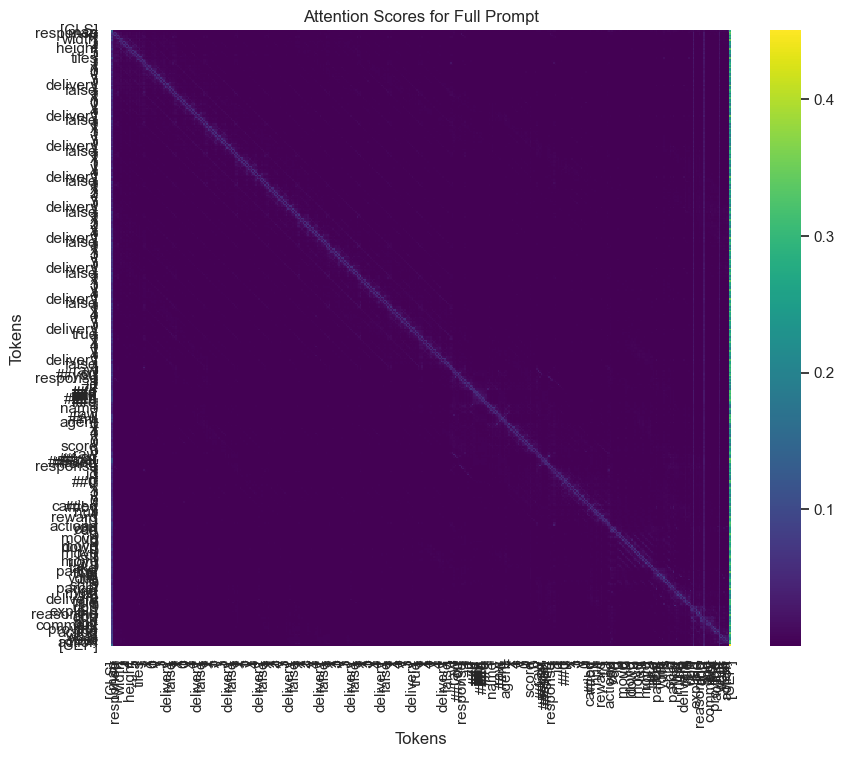

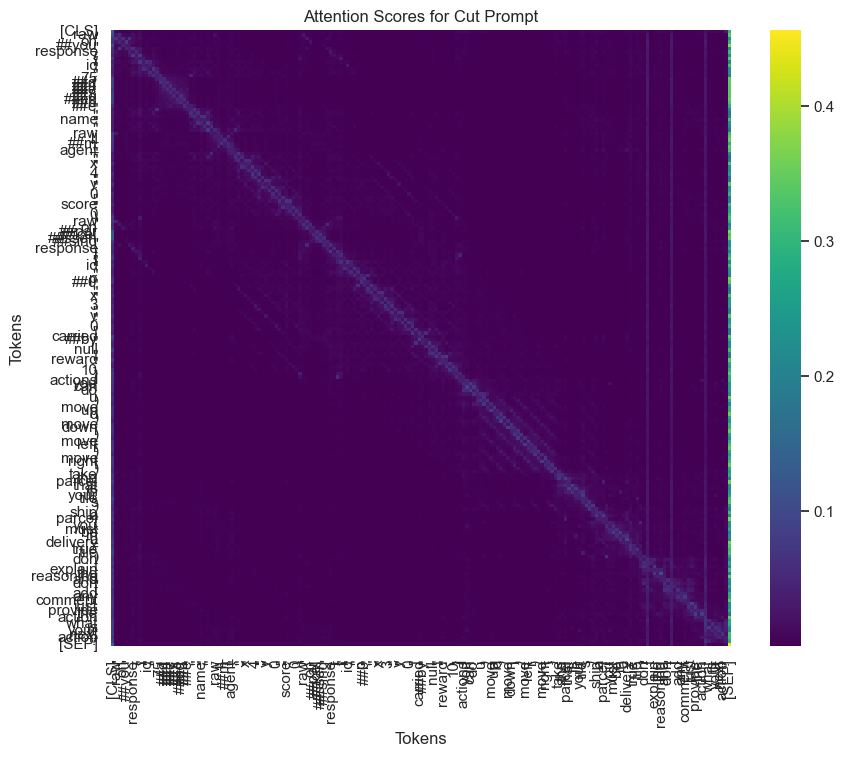

In [13]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load the text files
with open('promptFull.txt', 'r') as file:
    prompt_full = file.read()

with open('prompt.txt', 'r') as file:
    prompt_cut = file.read()

# Load a pre-trained model and tokenizer
model_name = 'bert-base-uncased'  # You can choose any model you prefer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Tokenize the prompts
inputs_full = tokenizer(prompt_full, return_tensors='pt')
inputs_cut = tokenizer(prompt_cut, return_tensors='pt')

# Get the attention scores
with torch.no_grad():
    outputs_full = model(**inputs_full)
    outputs_cut = model(**inputs_cut)

# Extract attention scores
attentions_full = outputs_full.attentions
attentions_cut = outputs_cut.attentions

# Average the attention scores across all heads, layers, and batch
avg_attentions_full = torch.mean(torch.stack(attentions_full), dim=(0, 1, 2)).squeeze()
avg_attentions_cut = torch.mean(torch.stack(attentions_cut), dim=(0, 1, 2)).squeeze()

# Plot the attention scores
def plot_attention(attentions, tokens, title):
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 8))
    sns.heatmap(attentions, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(title)
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

# Get the tokens
tokens_full = tokenizer.convert_ids_to_tokens(inputs_full['input_ids'].squeeze())
tokens_cut = tokenizer.convert_ids_to_tokens(inputs_cut['input_ids'].squeeze())

# Plot the attention for full and cut prompts
plot_attention(avg_attentions_full, tokens_full, 'Attention Scores for Full Prompt')
plot_attention(avg_attentions_cut, tokens_cut, 'Attention Scores for Cut Prompt')

# Remove the tokens only used in the prompt_full and plot the difference in attention between the new full and the cut prompt




In [24]:
start_i_to_remove = None
end_i_to_remove = None
for i, token in enumerate(tokens_full):
    if not start_i_to_remove and token != tokens_cut[i]:
        start_i_to_remove = i
    if start_i_to_remove and token == tokens_cut[start_i_to_remove]:
        end_i_to_remove = i-1
        break
print(start_i_to_remove, end_i_to_remove)

tokens_full_reduced = tokens_full[:start_i_to_remove] + tokens_full[end_i_to_remove+1:]


1 222


182 182
torch.Size([182, 404])
torch.Size([182, 182])
torch.Size([182, 182])


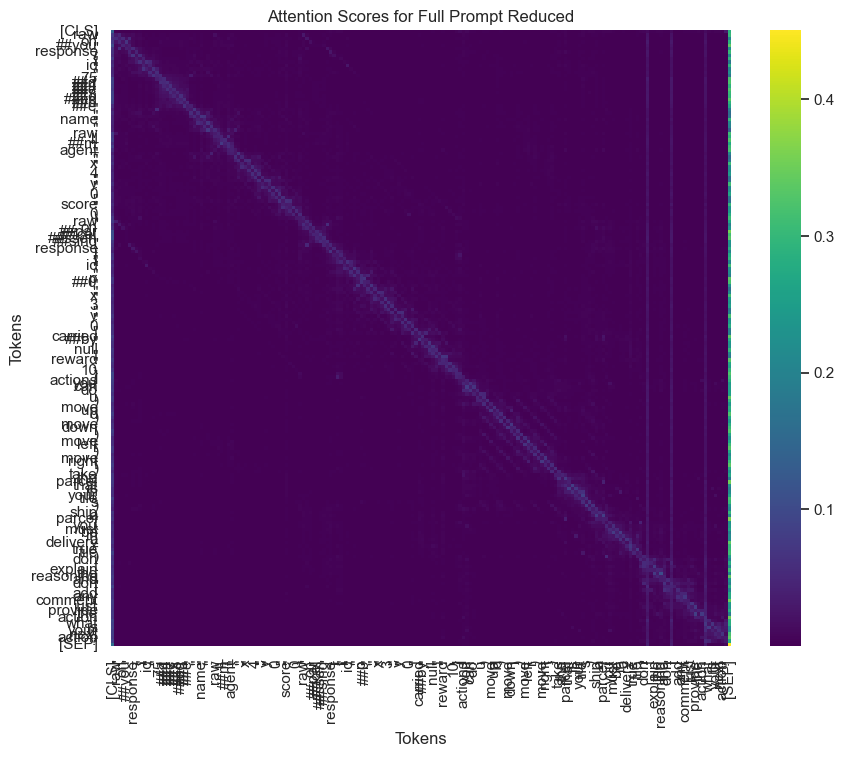

In [29]:
print(len(tokens_full_reduced), len(tokens_cut))
# remove all the attention relative to the removed tokens so that the two attentions have the same length
avg_attentions_full_reduced = torch.cat((avg_attentions_full[:start_i_to_remove], avg_attentions_full[end_i_to_remove+1:]))
print(avg_attentions_full_reduced.shape)
print(avg_attentions_cut.shape)
# from the second dimension, remove the attention relative to the removed tokens
avg_attentions_full_reduced = torch.cat((avg_attentions_full_reduced[:, :start_i_to_remove], avg_attentions_full_reduced[:, end_i_to_remove+1:]), dim=1)
print(avg_attentions_full_reduced.shape)

plot_attention(avg_attentions_full_reduced, tokens_full_reduced, 'Attention Scores for Full Prompt Reduced')

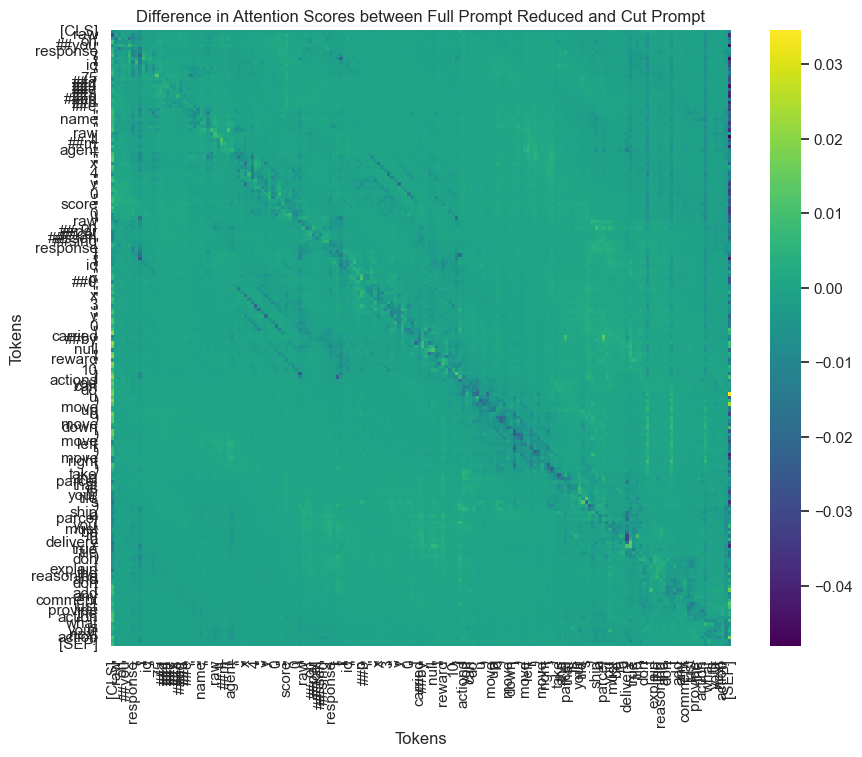

In [30]:
# plot the difference in attention between the new full and the cut prompt
diff = avg_attentions_full_reduced - avg_attentions_cut
plot_attention(diff, tokens_full_reduced, 'Difference in Attention Scores between Full Prompt Reduced and Cut Prompt')
